In [25]:
import pandas as pd
import numpy as np#
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, r2_score, accuracy_score, roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold

%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\shrey\AppData\Local\Temp\ipykernel_36908\1676925833.py:27: UserWarning: DelftStack
  warnings.warn('DelftStack')


## Step 1: Importing the data and data-preprocessing

In [2]:
data = pd.read_csv('heart_2020_cleaned.csv')
data2 = data.copy()
data2['Age_new']= data2['AgeCategory']

# clubbing the age features into the column Age_new
# <30, 30-45, 45-60, >60
data2.loc[data2['Age_new']=='18-24','Age_new'] = '<30'
data2.loc[data2['Age_new']=='25-29','Age_new'] = '<30'
data2.loc[data2['Age_new']=='30-34','Age_new'] = '30-44'
data2.loc[data2['Age_new']=='35-39','Age_new'] = '30-44'
data2.loc[data2['Age_new']=='40-44','Age_new'] = '30-44'
data2.loc[data2['Age_new']=='45-49','Age_new'] = '45-59'
data2.loc[data2['Age_new']=='50-54','Age_new'] = '45-59'
data2.loc[data2['Age_new']=='55-59','Age_new'] = '45-59'
data2.loc[data2['Age_new']=='60-64','Age_new'] = '60+'
data2.loc[data2['Age_new']=='65-69','Age_new'] = '60+'
data2.loc[data2['Age_new']=='70-74','Age_new'] = '60+'
data2.loc[data2['Age_new']=='75-79','Age_new'] = '60+'
data2.loc[data2['Age_new']=='80 or older','Age_new'] = '60+'

#dropping the old age column
data2 = data2.drop("AgeCategory", axis=1)

# processing the data - one-hot encoding
cont_cols = ['BMI','PhysicalHealth','MentalHealth','SleepTime']
cat_cols = []

for col in data2.columns.to_list():
    if col in cont_cols:
        continue
    else:
        cat_cols.append(col)

data_encoded = data2.copy()
one_hot_cols = cat_cols.copy()

for col in one_hot_cols:
    one_hot  = pd.get_dummies(data_encoded[col], prefix=col)
    one_hot_col = one_hot.columns.to_list()
    n_cols = len(one_hot_col)

    if n_cols ==2:
        for c1 in one_hot_col:
            if "No" in c1:
                one_hot = one_hot.drop(c1, axis=1)
    else:
        one_hot = one_hot.drop(one_hot_col[-1],axis=1)

    data_encoded = data_encoded.drop(col,axis=1)
    data_encoded = data_encoded.join(one_hot)

data_encoded = data_encoded.drop('Sex_Female', axis=1)
data_encoded.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_Yes,Smoking_Yes,AlcoholDrinking_Yes,Stroke_Yes,DiffWalking_Yes,Sex_Male,...,GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,Asthma_Yes,KidneyDisease_Yes,SkinCancer_Yes,Age_new_30-44,Age_new_45-59,Age_new_60+
0,16.60,3.0,30.0,5.0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
1,20.34,0.0,0.0,7.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,26.58,20.0,30.0,8.0,0,1,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
3,24.21,0.0,0.0,6.0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,1
4,23.71,28.0,0.0,8.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


## Step 2: Exploratory Data Analysis

1. Check the null values in each columns
2. Checking the correlations b/w continuous variables
3. Distribution of respondents for the two classes amongst continuous variables
3. Remaining EDA performed on Excel

In [3]:
data_encoded.info() # check null values and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 29 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   BMI                                  319795 non-null  float64
 1   PhysicalHealth                       319795 non-null  float64
 2   MentalHealth                         319795 non-null  float64
 3   SleepTime                            319795 non-null  float64
 4   HeartDisease_Yes                     319795 non-null  uint8  
 5   Smoking_Yes                          319795 non-null  uint8  
 6   AlcoholDrinking_Yes                  319795 non-null  uint8  
 7   Stroke_Yes                           319795 non-null  uint8  
 8   DiffWalking_Yes                      319795 non-null  uint8  
 9   Sex_Male                             319795 non-null  uint8  
 10  Race_American Indian/Alaskan Native  319795 non-null  uint8  
 11  Race_Asian   

Luckily, there's no missing data as Non-Null count matches with the actual count

In [4]:
data_encoded.nunique() # check for catogorical vs continous variables

BMI                                    3604
PhysicalHealth                           31
MentalHealth                             31
SleepTime                                24
HeartDisease_Yes                          2
Smoking_Yes                               2
AlcoholDrinking_Yes                       2
Stroke_Yes                                2
DiffWalking_Yes                           2
Sex_Male                                  2
Race_American Indian/Alaskan Native       2
Race_Asian                                2
Race_Black                                2
Race_Hispanic                             2
Race_Other                                2
Diabetic_No                               2
Diabetic_No, borderline diabetes          2
Diabetic_Yes                              2
PhysicalActivity_Yes                      2
GenHealth_Excellent                       2
GenHealth_Fair                            2
GenHealth_Good                            2
GenHealth_Poor                  

Most of the variables are catogorical as expected

<AxesSubplot:>

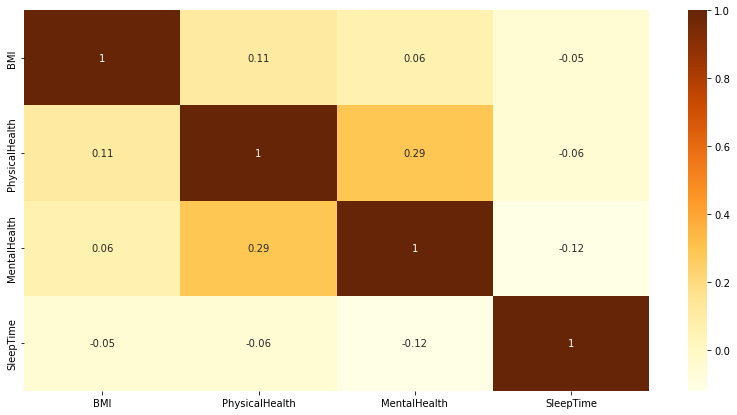

In [5]:
#correlation for continous variables

correlation = data_encoded[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']].corr().round(2) 
plt.figure(figsize = (14,7))
sns.heatmap(correlation, annot = True, cmap = 'YlOrBr')

No major correlation between the continuous variables

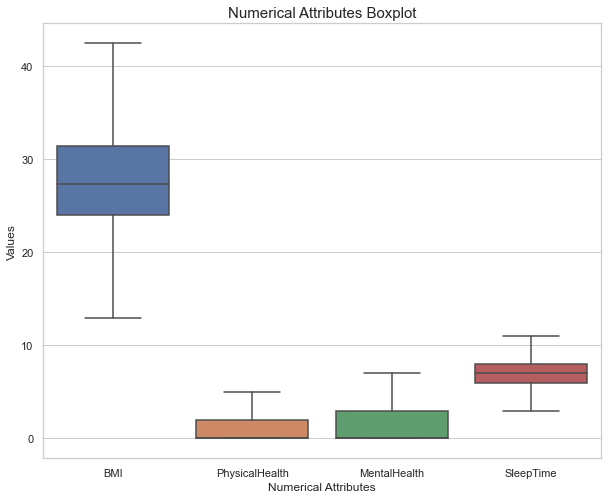

In [6]:
# continous variables distribution

df_numerical = data_encoded[['BMI','PhysicalHealth','MentalHealth', 'SleepTime']]

plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(data= df_numerical, showfliers=False)  # outliers are ignore to be plotted
plt.xlabel("Numerical Attributes", fontsize= 12)
plt.ylabel("Values", fontsize= 12)
plt.title("Numerical Attributes Boxplot", fontsize= 15)
plt.show()

From the above box plots we can see there aren't many outliers most of the data makes sense, the median values and the spread is in the expected range

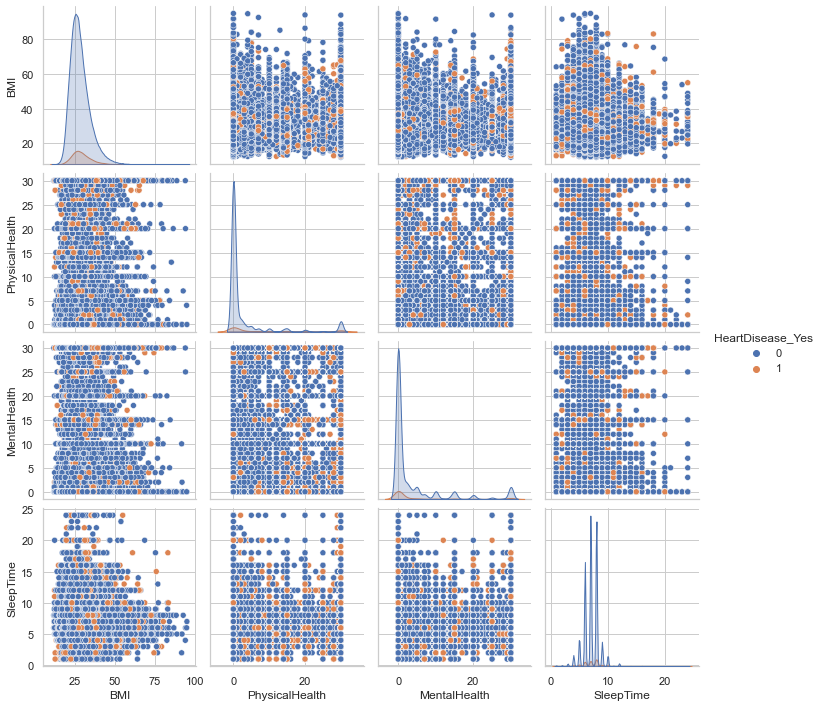

In [7]:
# Plotting pairplots to find any relationships between continous variables and HeartDisease_Yes

df_numerical = data_encoded[['BMI','PhysicalHealth','MentalHealth', 'SleepTime','HeartDisease_Yes']]
sns.pairplot(df_numerical, hue='HeartDisease_Yes')

As the classes are highly-imbalanced we don't see any meaningful insights from the pairplots

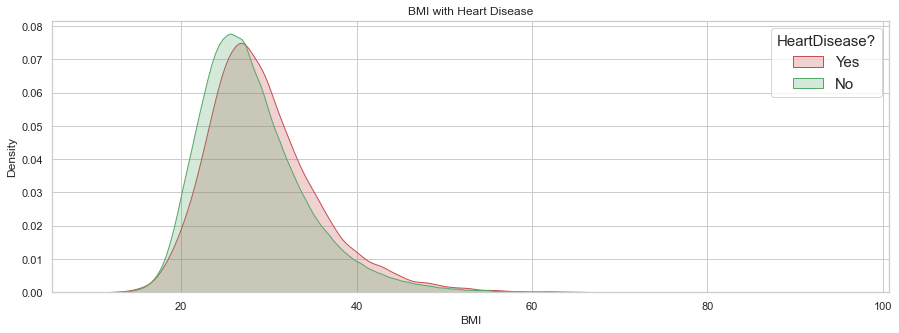

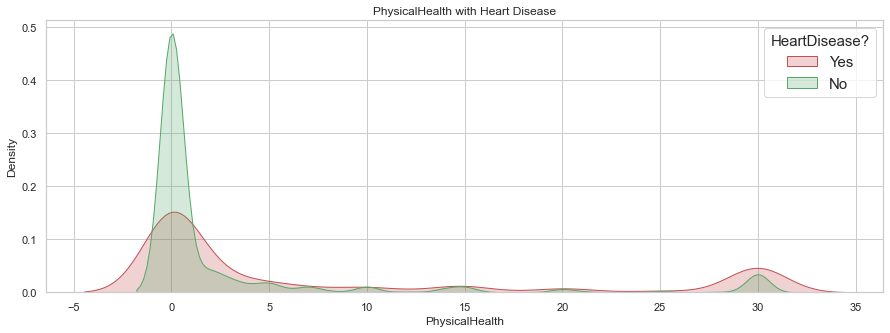

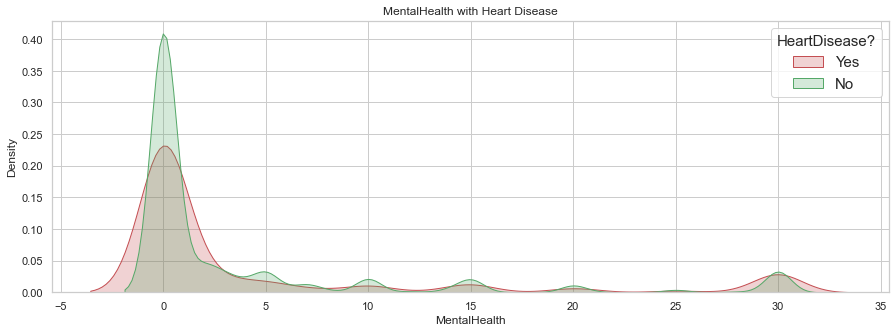

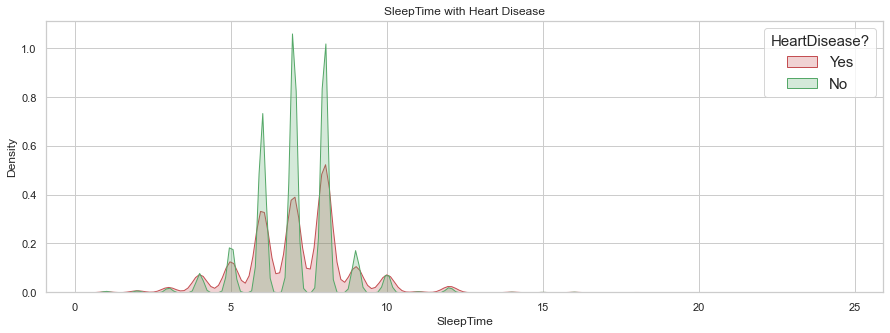

In [8]:
# Function definition to print the continous variables distribution for people with and people without Heart disease
def plot_kde(feature):
    figure, axis = plt.subplots(1, 1, figsize=(15, 5))
    sns.kdeplot(df_numerical.loc[(df_numerical['HeartDisease_Yes']==1), feature], color='r', shade=True, label='Yes')
    sns.kdeplot(df_numerical.loc[(df_numerical['HeartDisease_Yes']==0), feature], color='g', shade=True, label='No')
    plt.title(f'{feature} with Heart Disease')
    plt.legend(title='HeartDisease?', fontsize=15, title_fontsize=15)
    
    plt.show()

# Plot continous variables distribution with and without heartdisease

for feature in df_numerical.iloc[:, :-1]:
    plot_kde(feature)


Again, we don't see any major insights as the distributions for people with heart disease and without heartdisease is similar

We can explore the catogorical variable distributions for people with and without heart disease using excel for the ease of plotting them onto PPT - we are attaching an excel with the relevant data for the plots

 # Step 3: Model Building
1. Logistic Regression
2. Random Forest Classification
3. Decision Tree Classification
4. XG Boost
5. Ada Boost

### Model 1: Logistic Regression

In [9]:
# defining necessary functions

def run_LogisticReg(train_X, test_X, train_y, test_y, plot_graph, classification_thres, penalty_type, print_report ):
    
    model = LogisticRegression(class_weight='balanced',max_iter=5000, penalty=penalty_type, solver='lbfgs')
    model.fit(train_X, train_y)

    yhat = model.predict_proba(test_X)
    yhat_positive = yhat[:, 1]

    y_pred = (model.predict_proba(test_X)[:,1]>classification_thres).astype(bool)

    if print_report =='Yes':
        print(classification_report(test_y, y_pred))

    feature_importance = pd.DataFrame(train_X.columns, columns = ["feature"])
    feature_importance["importance"] = model.coef_[0]
    feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)

    if plot_graph == 'Yes':
        ax = feature_importance.plot.barh(x='feature', y='importance')
        plt.rcParams["figure.figsize"]=(10,10)
        plt.show()

    return yhat, yhat_positive, y_pred, feature_importance

def run_LogisticReg2(train_X, test_X, train_y, test_y, plot_graph, classification_thres, penalty_type ):
    
    model = LogisticRegression(max_iter=5000, penalty=penalty_type, solver='saga')
    model.fit(train_X, train_y)

    yhat = model.predict_proba(test_X)
    yhat_positive = yhat[:, 1]

    y_pred = (model.predict_proba(test_X)[:,1]>classification_thres).astype(bool)
    print(classification_report(test_y, y_pred))

    feature_importance = pd.DataFrame(train_X.columns, columns = ["feature"])
    feature_importance["importance"] = model.coef_[0]
    feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)
    
    if plot_graph == 'Yes':
        ax = feature_importance.plot.barh(x='feature', y='importance')
        plt.rcParams["figure.figsize"]=(5,5)
        plt.show()

    return yhat, yhat_positive, y_pred, feature_importance


def perform_cross_validation(X, y, n_splits1, classification_thres1, penalty_type1):

    kf = StratifiedKFold(n_splits=n_splits1,shuffle=True,random_state=50)
    
    pred_test_full =0
    recall_list = []
    precision_list = []
    accuracy_list = []
    roc_auc_list = []

    i=1

    for train_index,test_index in kf.split(X,y):
        
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = X.loc[train_index],X.loc[test_index]
        ytr,yvl = y.loc[train_index],y.loc[test_index]
        
        yhat, yhat_positive, y_pred, feature_importance = run_LogisticReg(train_X=xtr, train_y=ytr, test_X=xvl, test_y=yvl, plot_graph='No',classification_thres=classification_thres1, penalty_type= penalty_type1, print_report='No')
        
        precision = precision_score(y_pred=y_pred, y_true=yvl)
        recall = recall_score(y_pred=y_pred, y_true=yvl)
        accuracy = accuracy_score(y_pred=y_pred, y_true=yvl)
        roc_score = roc_auc_score(yvl, yhat_positive)

        #print("ROC_AUC: "+ str(roc_score))
        #print('\n')

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        roc_auc_list.append(roc_score)

        fpr, tpr, thresholds = metrics.roc_curve(yvl,  yhat_positive)
        length = len(thresholds)

        i+=1

    return precision_list, recall_list, accuracy_list, roc_auc_list

              precision    recall  f1-score   support

           0       0.97      0.74      0.84     58484
           1       0.22      0.77      0.34      5475

    accuracy                           0.74     63959
   macro avg       0.60      0.76      0.59     63959
weighted avg       0.91      0.74      0.80     63959



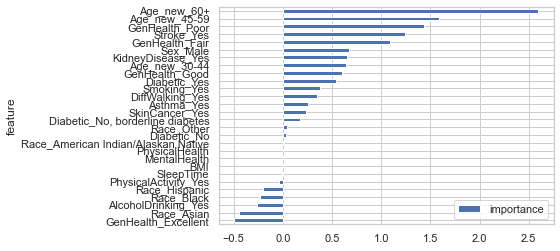

In [10]:
# running logistic regression considering all the features with l2 regularization

#X = data_encoded[['Smoking_Yes', 'AlcoholDrinking_Yes', 'Stroke_Yes', 'DiffWalking_Yes', 'Sex_Male',  'Race_Asian', 'Race_Black', 'Race_Hispanic',  'Diabetic_No, borderline diabetes', 'Diabetic_Yes',  'GenHealth_Excellent', 'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor', 'Asthma_Yes', 'KidneyDisease_Yes', 'SkinCancer_Yes', 'Age_new_30-44', 'Age_new_45-59', 'Age_new_60+']]
X = data_encoded.loc[:,~data_encoded.columns.isin(['HeartDisease_Yes'])].copy()
y = data_encoded['HeartDisease_Yes'].copy()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=20)

yhat, yhat_positive, y_pred, feature_importance = run_LogisticReg(train_X, test_X, train_y, test_y, plot_graph='Yes',classification_thres=0.5, penalty_type='l2', print_report='Yes' )



              precision    recall  f1-score   support

           0       0.97      0.74      0.84     87635
           1       0.22      0.78      0.34      8304

    accuracy                           0.74     95939
   macro avg       0.60      0.76      0.59     95939
weighted avg       0.91      0.74      0.80     95939



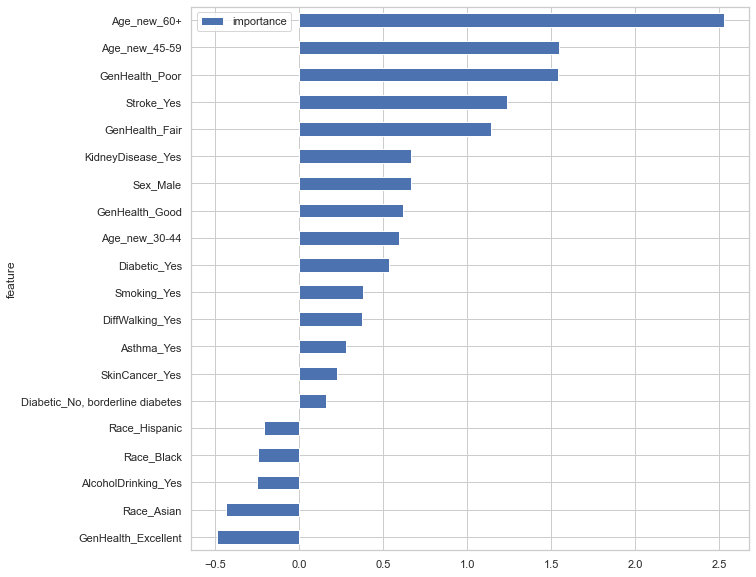

In [11]:
# running logistic regression considering all the features with l2 regularization on prunded features

# removing the features with had low coeffecients (abs value <0.05)
features_pruned_1 = feature_importance['feature'][(feature_importance['importance']<-0.05) | (feature_importance['importance']>0.05) ].to_list()

X = data_encoded.loc[:,data_encoded.columns.isin(features_pruned_1)].copy()
y = data_encoded['HeartDisease_Yes'].copy()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=20)

yhat, yhat_positive, y_pred, feature_importance = run_LogisticReg(train_X, test_X, train_y, test_y, plot_graph='Yes',classification_thres=0.5, penalty_type='l2' ,print_report='Yes')

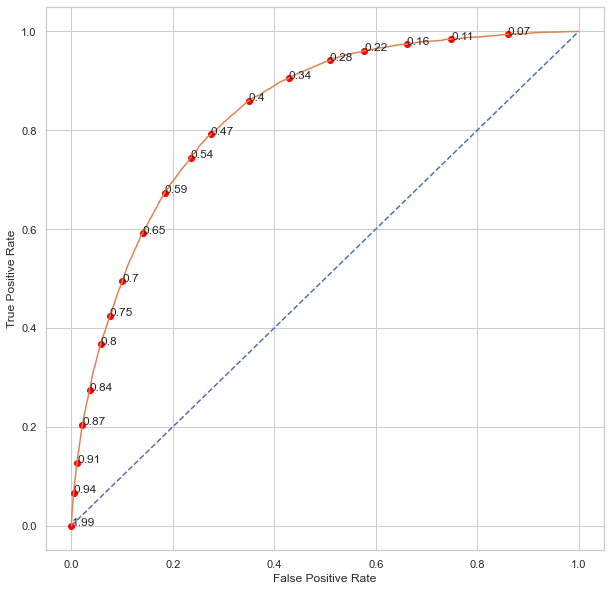

ROC_AUC: 0.84


In [12]:
# all the features after previous step have decent coefficients, hence we are going ahead with these set of features for our cross validation and ROC

# 1. performing cross validation to get the optimal classification threshold
fpr, tpr, thresholds = metrics.roc_curve(test_y,  yhat_positive)
length = len(thresholds)

plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, label='Logistic')
idx_list  =np.linspace(0,length, num=20).astype(int)

for ix in idx_list:
    try:
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=thresholds[ix])
        plt.text(fpr[ix], tpr[ix], str(round(thresholds[ix],2)))
    except:
        continue

#generating the roc curve plot
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.rcParams["figure.figsize"]=(5,5)
plt.show()

# getting the AUC score for the roc curve
roc_score = roc_auc_score(test_y, yhat_positive)
print("ROC_AUC: "+ str(round(roc_score,2)))

# based on the plot, we are considering classification threshold = 0.45

In [13]:
# 2. Performing cross validation to check for overfitting

#precision_list1, recall_list1, accuracy_list1, roc_auc_list1 = perform_cross_validation(train_X.reset_index(),train_y.reset_index()['HeartDisease_Yes'],n_splits1=5, penalty_type1='l2',classification_thres1 = 0.45)
precision_list1, recall_list1, accuracy_list1, roc_auc_list1 = perform_cross_validation(X,y,n_splits1=5, penalty_type1='l2',classification_thres1 = 0.45)

recall_list1 = list(np.round(np.array(recall_list1),3))
accuracy_list1 = list(np.round(np.array(accuracy_list1),3))
roc_auc_list1 = list(np.round(np.array(roc_auc_list1),3))
print("\n")

print("Recall scores in CV: "+ str(recall_list1) + " Mean: "+str(round(np.array(recall_list1).mean(),3)) + " Std Dev: "+str(round(np.array(recall_list1).std(),3)))
print("Accuracy scores in CV: "+ str(accuracy_list1)+" Mean: "+str(round(np.array(accuracy_list1).mean(),3)) + " Std Dev: "+str(round(np.array(accuracy_list1).std(),3)))
print("AUC (ROC) scores in CV: "+ str(roc_auc_list1)+" Mean: "+str(round(np.array(roc_auc_list1).mean(),3)) + " Std Dev: "+str(round(np.array(roc_auc_list1).std(),3)))

print("\n")
print("As you can see that the cross validation scores show very little variance, hence our model is not overfit and is generalized")

1 of KFold 5
2 of KFold 5
3 of KFold 5
4 of KFold 5
5 of KFold 5


Recall scores in CV: [0.821, 0.826, 0.841, 0.828, 0.82] Mean: 0.827 Std Dev: 0.008
Accuracy scores in CV: [0.706, 0.702, 0.692, 0.693, 0.701] Mean: 0.699 Std Dev: 0.005
AUC (ROC) scores in CV: [0.834, 0.834, 0.838, 0.831, 0.831] Mean: 0.834 Std Dev: 0.003


As you can see that the cross validation scores show very little variance, hence our model is not overfit and is generalized


### Model 3: Decision Tree

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.70      0.81     87649
           1       0.20      0.80      0.32      8290

    accuracy                           0.71     95939
   macro avg       0.59      0.75      0.57     95939
weighted avg       0.91      0.71      0.77     95939

AUROC: 0.821
 


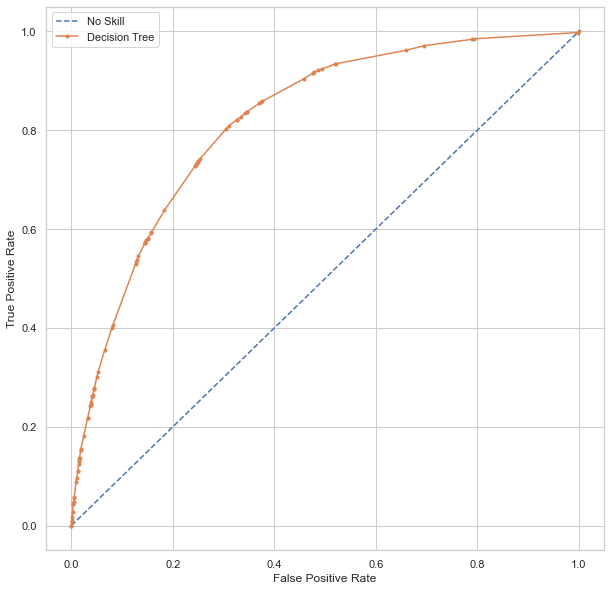

<AxesSubplot:>

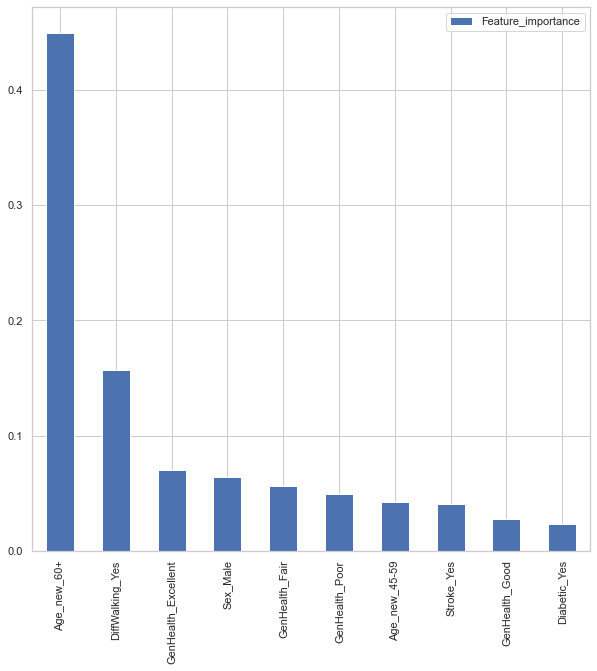

In [14]:
x = data_encoded.drop('HeartDisease_Yes', axis = 1)
y = data_encoded['HeartDisease_Yes']
x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3,random_state=42)

#Decision_Tree_Model
model = DecisionTreeClassifier(class_weight='balanced',max_depth=7)
model.fit(x_training_data, y_training_data)
yhat = model.predict_proba(x_test_data)
yhat_positive = yhat[:, 1]
predictions = model.predict(x_test_data)


#classification report
print("Classification report:")
print(classification_report(y_test_data, predictions))
accuracy = accuracy_score(y_test_data,predictions)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, x, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('AUROC: %.3f' % np.mean(scores))
print(" ")

# plot no skill roc curve - the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
fpr, tpr, thresholds = roc_curve(y_test_data, yhat_positive)
# plot roc curve
plt.plot(fpr, tpr, marker='.', label='Decision Tree')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
print(" ")


#Feature Importance
feature_names = x.columns.to_list()
importances = model.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.to_frame()
forest_importances.rename(columns={ 0: "Feature_importance" }, inplace = True)
forest_importances.sort_values(["Feature_importance"],ascending=False, inplace = True)
forest_importances.iloc[:10].plot(kind="bar")

### Model 4: XGBoost

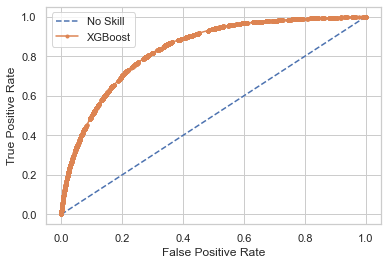

AUROC: 0.837
Accuracy = 0.6988287113144164
Precision Score = 0.19916366258111032
Recall Score = 0.8316473988439307
Specificity = 0.6831288868602727
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     87635
           1       0.20      0.83      0.32      8304

    accuracy                           0.70     95939
   macro avg       0.59      0.76      0.56     95939
weighted avg       0.91      0.70      0.76     95939



In [16]:

#XGBoost
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 20,
            'alpha': 10,
            'learning_rate': 0.1,
            'n_estimators':100
        }   

#XGBoost Algorithm
xgb = XGBClassifier(**params)
sample_weights = np.zeros(len(train_y))
sample_weights[train_y == 0] = 0.5
sample_weights[train_y == 1] =6
xgb.fit(train_X,train_y,sample_weight=sample_weights)
yhat = xgb.predict_proba(test_X)
yhat_positive = yhat[:, 1]
y_pred = xgb.predict(test_X)
# plot no skill roc curve - the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate inputs for the roc curve
fpr, tpr, thresholds = roc_curve(test_y, yhat_positive)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='XGBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

# calculate and print area under ROC curve
roc_auc = roc_auc_score(test_y, yhat_positive)
print('AUROC: %.3f' % roc_auc)

#Calculate accuracy, precision_score, recall_score, specificity, confusion matrix and classification report
accuracy = xgb.score(train_X, train_y)
print('Accuracy =',accuracy)
ps = precision_score(test_y, y_pred)
print('Precision Score =',ps)
rs = recall_score(test_y, y_pred)
print('Recall Score =',rs)
tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity =',specificity)
cm = confusion_matrix(test_y, y_pred)

print(classification_report(test_y, y_pred))



XGBoost Feature Importance Graph

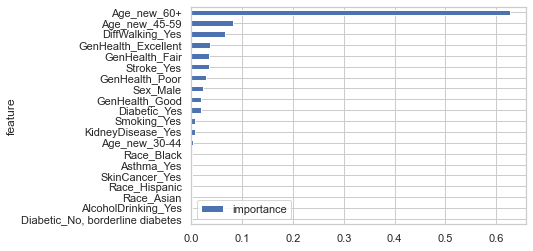

In [18]:

feature_importance = pd.DataFrame(train_X.columns, columns = ["feature"])
feature_importance["importance"] = xgb.feature_importances_
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)

ax = feature_importance.plot.barh(x='feature', y='importance')
plt.rcParams["figure.figsize"]=(5,5)
plt.show()


### Model 5: AdaBoost 

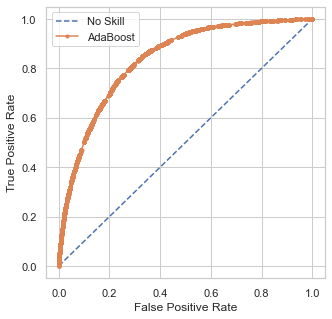

AUROC: 0.838
Accuracy = 0.6988287113144164
Precision Score = 0.20668026672350273
Recall Score = 0.8174373795761078
Specificity = 0.7026872824784618
              precision    recall  f1-score   support

           0       0.98      0.70      0.82     87635
           1       0.21      0.82      0.33      8304

    accuracy                           0.71     95939
   macro avg       0.59      0.76      0.57     95939
weighted avg       0.91      0.71      0.77     95939



In [19]:


#AdaBoost
# training test splitting
train_X, test_X, train_y, test_y = train_test_split(X, y.ravel(), test_size=0.3, random_state=20)

#AdaBoost Algo
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),  n_estimators = 50, random_state=0,learning_rate=0.2)
sample_weights = np.zeros(len(train_y))
sample_weights[train_y == 0] = 0.5
sample_weights[train_y == 1] = 6
model.fit(train_X,train_y,sample_weight=sample_weights)
yhat = model.predict_proba(test_X)
yhat_positive = yhat[:, 1]
y_pred = model.predict(test_X)


# plot no skill roc curve - the diagonal line
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# calculate inputs for the roc curve
fpr, tpr, thresholds = roc_curve(test_y, yhat_positive)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='AdaBoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()

# calculate and print area under ROC curve
roc_auc = roc_auc_score(test_y, yhat_positive)
print('AUROC: %.3f' % roc_auc)

#Calculate accuracy, precision_score, recall_score, specificity, confusion matrix and classification report
accuracy = xgb.score(train_X, train_y)
print('Accuracy =',accuracy)
ps = precision_score(test_y, y_pred)
print('Precision Score =',ps)
rs = recall_score(test_y, y_pred)
print('Recall Score =',rs)
tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity =',specificity)
cm = confusion_matrix(test_y, y_pred)

print(classification_report(test_y, y_pred))

AdaBoost Feature Importance Graph

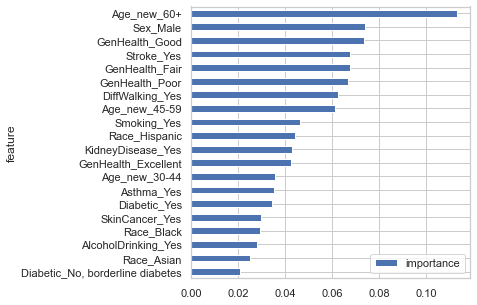

In [20]:
feature_importance = pd.DataFrame(train_X.columns, columns = ["feature"])
feature_importance["importance"] = model.feature_importances_
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=True)
ax = feature_importance.plot.barh(x='feature', y='importance')
plt.rcParams["figure.figsize"]=(5,5)
plt.show()

### Model 5: Random Forest Classification

In [22]:
def run_RandomForest(X_train, X_test, Y_train, Y_test, classification_thres ):
    
    #Random Forest model
    rf = RandomForestClassifier(n_estimators= 10, max_depth= 12, class_weight='balanced')
    rf.fit(X_train, Y_train)
    yhat = rf.predict_proba(X_test)
    yhat_positive = yhat[:, 1]
    y_pred = rf.predict(X_test)
    
    y_pred = (rf.predict_proba(X_test)[:,1]>0.45).astype(bool)
    print(classification_report(Y_test, y_pred))
    
    # calculate inputs for the roc curve
    fpr, tpr, thresholds = roc_curve(Y_test, yhat_positive)

    #Calculate ROC Score
    roc_score = roc_auc_score(Y_test, yhat_positive)
    print("ROC_AUC: "+ str(roc_score))
    print('\n')
    
    return yhat, yhat_positive, y_pred

#Cross Validation function

def perform_cross_validation(X, y, n_splits1):

    kf = StratifiedKFold(n_splits=n_splits1,shuffle=True,random_state=42)
    pred_test_full =0
    recall_list = []
    precision_list = []
    accuracy_list = []
    roc_auc_list = []
    i=1

    for train_index,test_index in kf.split(X,y):
        
        print('{} of KFold {}'.format(i,kf.n_splits))
        xtr,xvl = X.loc[train_index],X.loc[test_index]
        ytr,yvl = y.loc[train_index],y.loc[test_index]
        
        yhat, yhat_positive, y_pred = run_RandomForest(X_train=xtr, Y_train=ytr, X_test=xvl, Y_test=yvl, classification_thres=0.45)
        
        precision = precision_score(y_pred=y_pred, y_true=yvl)
        recall = recall_score(y_pred=y_pred, y_true=yvl)
        accuracy = accuracy_score(y_pred=y_pred, y_true=yvl)
        roc_score = roc_auc_score(yvl, yhat_positive)

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        roc_auc_list.append(roc_score)

        fpr, tpr, thresholds = metrics.roc_curve(yvl,  yhat_positive)
        length = len(thresholds)

        plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
        plt.plot(fpr, tpr, label='Logistic')
        idx_list  =np.linspace(0,length, num=20).astype(int)

        for ix in idx_list:
            try:
                plt.scatter(fpr[ix], tpr[ix], marker='o', color='red', label=thresholds[ix])
                plt.text(fpr[ix], tpr[ix], str(round(thresholds[ix],2)))
            except:
                continue

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        i+=1

    return precision_list, recall_list, accuracy_list, roc_auc_list

In [23]:
#Reading the data file 
df = data_encoded.copy()

# X= Independent Variables and Y= Dependent Variable(Heart Disease)
X = df.drop(labels='HeartDisease_Yes',axis=1)
Y = df['HeartDisease_Yes']

#Splitting the data into Training and Testing data sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, train_size = 0.80, random_state= 42)

#Calling the Random Forest Function
yhat, yhat_positive, y_pred = run_RandomForest(X_train, X_test, Y_train, Y_test,classification_thres=0.45 )

              precision    recall  f1-score   support

           0       0.97      0.68      0.80     58367
           1       0.19      0.82      0.31      5592

    accuracy                           0.69     63959
   macro avg       0.58      0.75      0.56     63959
weighted avg       0.91      0.69      0.76     63959

ROC_AUC: 0.8206222819335196




<AxesSubplot:xlabel='Ival'>

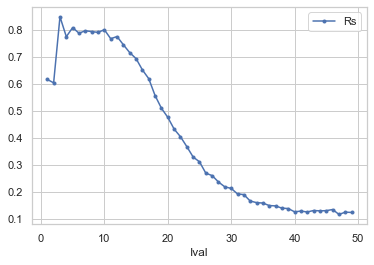

In [29]:
#To find the optimal tree depth
df = pd.DataFrame(columns=['Ival','Rs'])

for i in range(1,50):
    rf = RandomForestClassifier(n_estimators= 10, max_depth= i, class_weight='balanced')
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_test)
    rs = recall_score(Y_test, y_pred)
    df=df.append({'Ival':i,'Rs':rs},ignore_index=True)
#print(df)
df.plot.line(x='Ival',y='Rs',style='.-')

<AxesSubplot:xlabel='n_estimators'>

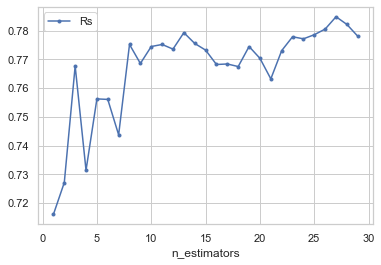

In [27]:
#To find the optimal number of estimators
warnings.simplefilter(action='ignore', category=FutureWarning)
df = pd.DataFrame(columns=['n_estimators','Rs'])

for j in range(1,30):
    rf = RandomForestClassifier(n_estimators= j, max_depth= 12, class_weight='balanced')
    rf.fit(X_train, Y_train)
    y_pred = rf.predict(X_test)
    rs = recall_score(Y_test, y_pred)
    df=df.append({'n_estimators':j,'Rs':rs},ignore_index=True)
#print(df)
df.plot.line(x='n_estimators',y='Rs',style='.-')

1 of KFold 5
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     58485
           1       0.20      0.83      0.32      5474

    accuracy                           0.70     63959
   macro avg       0.59      0.76      0.56     63959
weighted avg       0.91      0.70      0.76     63959

ROC_AUC: 0.8291646140932369




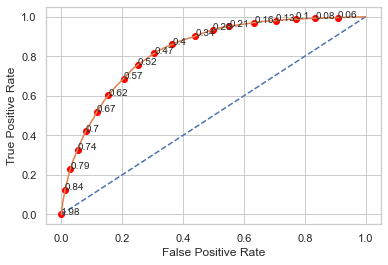

2 of KFold 5
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     58485
           1       0.20      0.81      0.32      5474

    accuracy                           0.70     63959
   macro avg       0.59      0.75      0.56     63959
weighted avg       0.91      0.70      0.77     63959

ROC_AUC: 0.8231324564795867




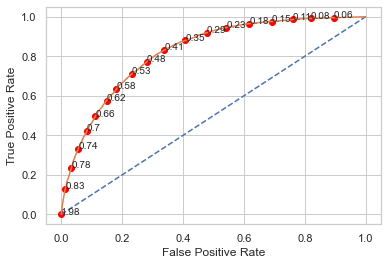

3 of KFold 5
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     58484
           1       0.20      0.82      0.32      5475

    accuracy                           0.70     63959
   macro avg       0.59      0.75      0.56     63959
weighted avg       0.91      0.70      0.77     63959

ROC_AUC: 0.8245921329144701




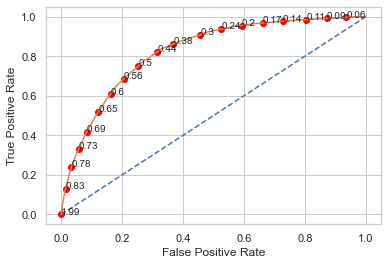

4 of KFold 5
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     58484
           1       0.19      0.80      0.31      5475

    accuracy                           0.70     63959
   macro avg       0.58      0.74      0.56     63959
weighted avg       0.91      0.70      0.76     63959

ROC_AUC: 0.8197924359126907




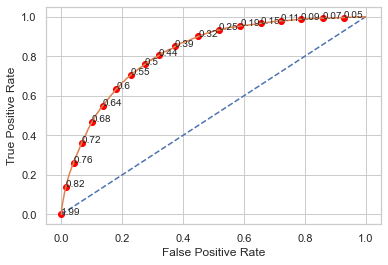

5 of KFold 5
              precision    recall  f1-score   support

           0       0.98      0.68      0.80     58484
           1       0.19      0.82      0.31      5475

    accuracy                           0.69     63959
   macro avg       0.58      0.75      0.56     63959
weighted avg       0.91      0.69      0.76     63959

ROC_AUC: 0.8223186968515604




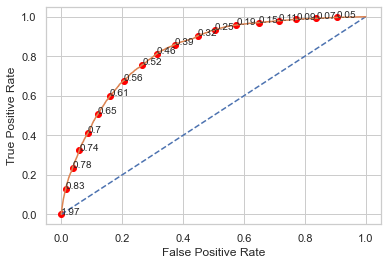

In [28]:
# Cross validation
precision_list1, recall_list1, accuracy_list1, roc_auc_list1 = perform_cross_validation(X,Y,5)